In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from abstractModel import build_model, compare_result

import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    if os.name == 'posix':
        MODELS_PATH = module_path+"/models"
        DATA_PATH = module_path+"/data"
        DATASET_PATH = DATA_PATH+"/merged_sessions_products_data"
        sys.path.append(module_path+"/models")
    else:
        MODELS_PATH = module_path+"\\models"
        DATA_PATH = module_path+"\\data"
        DATASET_PATH = DATA_PATH+"\\merged_sessions_products_data"
        sys.path.append(module_path+"\\models")

sessions_dataset = pd.read_csv(DATASET_PATH, sep=' ')

## Usunięcie redundantnych atrybutów

Ze zbioru danych, używanego do uczenia modeli, usunięte zostały informacje o id użytkownika oraz id sesji, jako dane identyfikujące.

In [119]:
 sessions_dataset = sessions_dataset.drop(['user_id','session_id'], axis=1)

## One-hot encoding dla danych zawierających labele, a nie wartości

Dla wartości liczbowych, reprezentujących wysokość udzielonej zniżki na produkt oraz reprezentujących dzień tygodnia w którym dokonywany jest zakup, zastosowane zostało kodowanie 1 z n. Wartości te bowiem reprezentują kategorie w których zamykać mogą się dwa powyższe atrybuty, które są oddzielne i dla których reprezentacja liczbowa mogłaby implikować niepoprawne relacje między nimi.

In [120]:
sessions_dataset = pd.get_dummies(sessions_dataset, columns = ['offered_discount', 'weekday'])

## Podział zbioru na podzbiory: testowy i treningowy

Postanowiliśmy podzielić zbiór danych uzyskany z łączenia danych w proporcji: 12% danych testowych i 88% danych treningowych. Zdefiniowaliśmy również zależność wyboru danych treningowych i testowych od pewnego konkretnego ziarna losowego w tym konkretnym momencie.

In [121]:
rand_seed = 116
test_data_percentage = 0.2

X = sessions_dataset.drop('event_type', axis=1)
Y = sessions_dataset[['event_type']]
num_records = len(sessions_dataset)

X_train_data, X_test_data, Y_train_data, Y_test_data = train_test_split(X, Y, test_size = test_data_percentage, random_state = rand_seed)

print('Size of entire dataset: ', num_records)
print('Size of training set: ', len(X_train_data))
print('Size of test set: ', len(X_test_data))

Size of entire dataset:  37003
Size of training set:  29602
Size of test set:  7401


In [122]:
X_train_data.head()

,product_id,weekend,day,hour,distance,price,Telefony i akcesoria,Telefony stacjonarne,Komputery,Drukarki i skanery,...,offered_discount_10,offered_discount_15,offered_discount_20,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
6809,1234,True,3,7,0,193.00,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
19456,1001,True,13,4,566,58.97,True,True,False,False,...,0,0,0,0,0,0,0,0,0,1
23778,1047,False,11,6,566,89.90,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
20585,1316,False,29,16,311,249.00,True,False,False,False,...,0,0,0,0,0,0,1,0,0,0
7472,1002,True,16,3,566,2048.50,False,False,True,True,...,0,0,0,0,0,0,0,0,0,1


## Usunięcie powiązanych ze sobą atrybutów

Aby wyznaczyć istotnie ważne atrybuty które pozwolą na zbudowanie skutecznego modelu, wyliczyliśmy wartości korelacji między wszystkimi atrybutami metodą korelacji rangowej Spearmana. Wyniki obliczeń zostały przedstawione poniżej.

<AxesSubplot:>

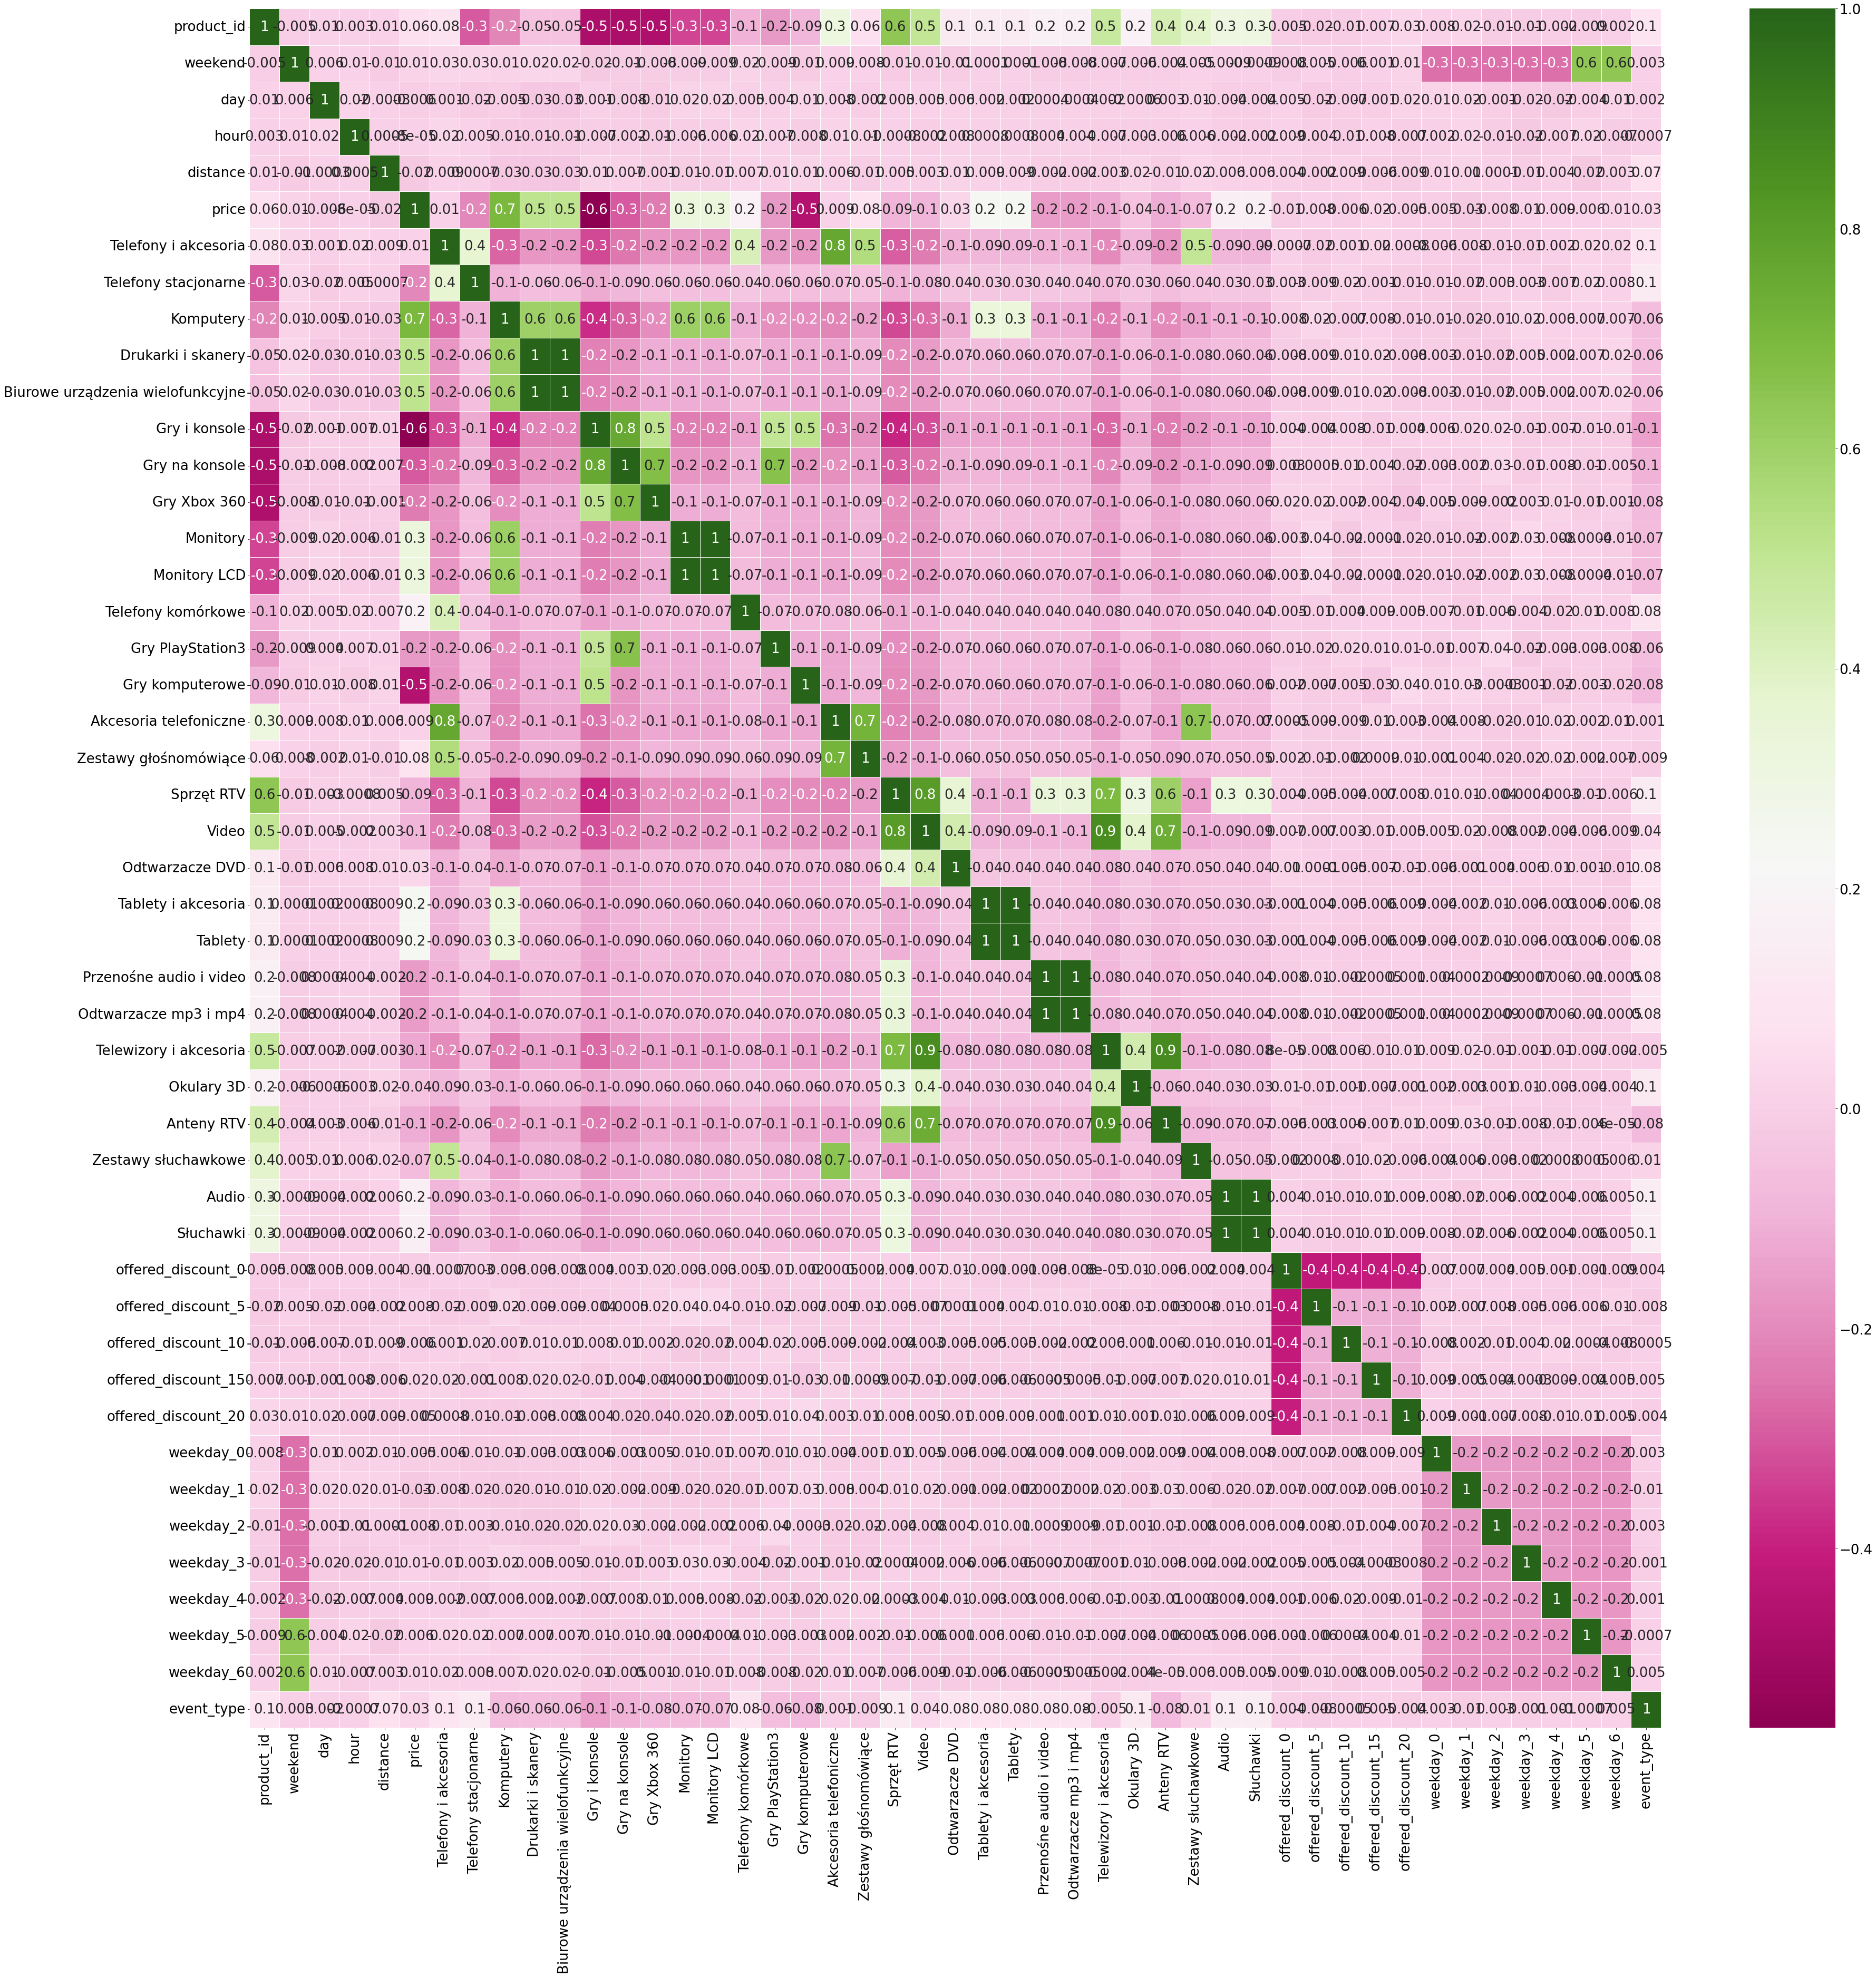

In [123]:
plt.rcParams.update({'font.size': 26})
plt.rcParams['figure.figsize'] = [60, 60]
train_figure_data = pd.concat([X_train_data, Y_train_data], axis=1)
color_map = plt.get_cmap('PiYG').copy()   # default color
color_map.set_bad('lightblue')


sns.heatmap(
    train_figure_data.corr(method = 'spearman'),
    xticklabels = train_figure_data.columns,
    yticklabels = train_figure_data.columns,
    linewidths = .5,
    cmap = color_map,
    annot = True,
    fmt = '0.1g',
)

Z wyliczeń wynika, że bardzo dużą korelację posiadają atrybuty związane z podobnymi znaczeniowo kategoriami produktów rozpatrywanych przez użytkowników w badanych sesjach. Wskazanym byłoby usunięcie skorelowanych atrybutów poprzez wybór atrybutu, dla którego mniejsza jest wyliczona w następnym kroku miara chi².

## Wykonanie testu Chi² na wszystkich atrybutach

In [124]:
def chi_sq(two_attributes_values_array, categories=[-1, -1]): 
    
    categories_array = []
    
    for i in range(2):
        if categories[i] <= -1:
            categories_array.append(np.sort
                                    (np.unique
                                     (two_attributes_values_array[:, i]))
                                        .tolist())
            
        else:
            categories_array.append(np.linspace(
                                    np.amin(two_attributes_values_array[:, i]),
                                    np.amax(two_attributes_values_array[:, i]), 
                                    categories[i])
                                    .tolist())
            
    freq_of_occurence_array = np.zeros((len(categories_array[0]), 
                                        len(categories_array[1])))
    
    for row_of_two_attr in two_attributes_values_array:
        index_first_col = sum(n <= row_of_two_attr[0] 
                              for n in categories_array[0])
        index_second_col = sum(n <= row_of_two_attr[1] 
                               for n in categories_array[1])
        freq_of_occurence_array[index_first_col-1][index_second_col-1] += 1

    n = np.sum(freq_of_occurence_array)
    n_i_array = np.sum(freq_of_occurence_array, axis=1)
    n_j_array = np.sum(freq_of_occurence_array, axis=0)
    chi = 0
    
    for i in range(freq_of_occurence_array.shape[0]):
        for j in range(freq_of_occurence_array.shape[1]):
            expected = (n_i_array[i]*n_j_array[j])/n
            
            if freq_of_occurence_array[i][j] == 0:
                continue
                
            chi += (freq_of_occurence_array[i][j]-expected)**2/expected
    return chi

In [125]:
scores_list =[]

feature_ranking = SelectKBest(chi2, k=5).fit(X_train_data, Y_train_data)

for n, (fitness, attribute) in enumerate(zip(feature_ranking.scores_, X_train_data.columns)):
    scores_list.append((fitness, attribute))
    
scores_frame = pd.DataFrame(scores_list) 
scores_frame = scores_frame.sort_values(by=[0], ascending = False)
scores_frame = scores_frame[[1,0]].rename({0: 'Chi Squared Score', 1: 'Attribute Name'}, axis=1)

display(scores_frame)

,Attribute Name,Chi Squared Score
5,price,66746.174544
4,distance,15766.406914
0,product_id,7098.980745
33,Słuchawki,560.749484
32,Audio,560.749484
7,Telefony stacjonarne,484.693351
29,Okulary 3D,462.729114
11,Gry i konsole,424.355011
21,Sprzęt RTV,357.565089
12,Gry na konsole,257.665111


Usunięte zostaną z wejścia modelu te atrybuty, które mają bardzo niską wartość statystyki korelacji - to jest wartość mniejszą niż 5. Okazuje się jednak, że trzeba arbitralnie podjąć decyzję o usunięciu poszczególnych kategorii produktów z wejścia modelu uczenia maszynowego. Są to bowiem kategorie ściśle współistniejące ze sobą, co wyrażone jest poprzez te same wartości metryki chi². Z tego powodu zdecydowaliśmy usunąć atrybuty: Audio, Przenośne audio i video, Tablety, Monitory LCD oraz	Biurowe urządzenia wielofunkcyjne, zostawiając odpowiadające im atrybuty.

## Prezentacja ostatecznych wejść i wyjść konstruowanych modelów

Danymi wejściowymi naszego modelu są:

- duration - długość trwania sesji
- price - cena oglądanego obecnie produktu
- click_rate - liczba eventów przypisanych do poszczególnego rekordu
- last_session_purchase - zmienna odpowiadająca na pytanie, czy sesja zakończyła się zakupem
- hour - godzina dokonywania zakupu
- month_2, month_3, month_4, month_7, month_8 - one-hot encoding miesięcy, z których wybrane zostały te o największym znaczeniu w kontekście modelu.
- offered_discount_10, offered_discount_15 - one-hot encoding zniżek nadanych oglądanym produktom, z których wybrane zostały te o największym znaczeniu w kontekście modelu.
- weekday_0.0, weekday_1.0 - one-hot encoding dni tygodnia w których dokonywane zostaje oglądanie produktów, z których wybrane zostały te o największym znaczeniu w kontekście modelu.

Jedyną daną wyjściową modelu jest predykcja w postaci wartości logicznej prawda/fałsz. Zwróci ona prawdę, jeżeli zmienna celu określająca prawdopodobieństwo tego, czy dana sesja zakończy się zakupem, będzie większa od pewnej wartości granicznej. 

In [139]:
sessions_dataset = pd.read_csv(DATASET_PATH, sep=' ')

one_hots = ['offered_discount', 'weekday']

dropped_attributes_list = list(scores_frame[scores_frame['Chi Squared Score'] < 5]['Attribute Name'])
dropped_attributes_list.extend(['session_id', 'user_id'])

dropped_attributes_list_with_cor = dropped_attributes_list[:]
dropped_attributes_list_with_cor.extend(["Audio", "Przenośne audio i video", "Tablety", "Monitory LCD", "Biurowe urządzenia wielofunkcyjne"])

results = {}

## Model bazowy - regresja logistyczna

In [140]:
def logistic_fn_tuning(X_train, Y_train):
    # hyperparameters tuning
    model = LogisticRegression(max_iter=500)
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rand_seed)

    # define search space
    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['l2']
    space['C'] = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rand_seed)
    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=rand_seed)
    search.fit(X_train, Y_train.values.ravel())
    
    print(search.best_estimator_) # model = LogisticRegression(C=0.01, max_iter=500, solver='newton-cg')
    return search.best_estimator_

# logistic_fn_tuning(X_train_data, Y_train_data)
def logistic_fn(X_train, Y_train):
    model = LogisticRegression(C=0.1, max_iter=500, solver='liblinear')
    model.fit(X_train, Y_train)
    
    return model

results['Logistic Regression with corelated attributes'] = \
    build_model(logistic_fn, 
                sessions_dataset,
                one_hots, 
                dropped_attributes_list, 
                'event_type', 
                rand_seed, 
                test_data_percentage)

results['Logistic Regression without corelated attributes'] = \
    build_model(logistic_fn, 
                sessions_dataset, 
                one_hots, 
                dropped_attributes_list_with_cor, 
                'event_type', 
                rand_seed, 
                test_data_percentage, 
                output = MODELS_PATH+'/logistic_reg.pkl')

## Zaawansowany model docelowy - drzewa losowe

In [141]:
def random_forest_fn_tuning(X_train,Y_train):
    model = RandomForestClassifier()
    
    # define evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=rand_seed)
    
    # define search space
    space = dict()
    space['n_estimators'] = [100, 200, 250, 300, 350, 400, 500, 800, 1200]
    space['max_depth'] = [5, 8, 10, 15, 20, 25, 30]
    space['min_samples_split'] = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
    space['min_samples_leaf'] = [1, 2, 5, 10] 
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rand_seed)
    search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=rand_seed)
    search.fit(X_train, Y_train)
    
    print(search.best_estimator_) # RandomForestClassifier(max_depth=25, min_samples_split=15, n_estimators=300)
    
    return search.best_estimator_

def random_forest_fn(X_train,Y_train):
    model = RandomForestClassifier(max_depth=9, min_samples_split=15, n_estimators=300) 
    model.fit(X_train, Y_train)
    
    return model
    
results['Random_Forest with corelated attributes'] = \
    build_model(random_forest_fn, 
                sessions_dataset, 
                one_hots, 
                dropped_attributes_list,
                'event_type', 
                rand_seed)
results['Random_Forest without corelated attributes'] = \
    build_model(random_forest_fn, 
                sessions_dataset, 
                one_hots, 
                dropped_attributes_list_with_cor, 
                'event_type', 
                rand_seed, 
                output=MODELS_PATH+'/random_forest.pkl')

## Porównanie wyników prezentowanych przez modele

In [142]:
data_scopes = ['training', 'test']
prediciton_models_records = []

for model_name in results:
    for data_type in data_scopes:
        temp_record = []
        for i in results[model_name][data_type]:
            temp_record.append(results[model_name][data_type][i]) 
        prediciton_models_records.append(temp_record)
                
model_comparison_frame = pd.DataFrame.from_records(prediciton_models_records)
model_comparison_frame.columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
model_comparison_frame.index = ['LR with corelated attributes / training data', 'LR with corelated attributes / test data', 
            'LR without corelated attributes / training data', 'LR without corelated attributes / test data', 
            'RF with corelated attributes / training data', 'RF with corelated attributes / test data', 
            'RF without corelated attributes / training data', 'RF without corelated attributes / test data']

display(model_comparison_frame)

,Accuracy,Precision,Recall,F1_score
LR with corelated attributes / training data,0.846936,0.552239,0.016282,0.031631
LR with corelated attributes / test data,0.842859,0.260870,0.010517,0.020219
LR without corelated attributes / training data,0.846936,0.552239,0.016282,0.031631
LR without corelated attributes / test data,0.842859,0.260870,0.010517,0.020219
RF with corelated attributes / training data,0.847172,0.536332,0.034103,0.064129
RF with corelated attributes / test data,0.840832,0.259740,0.017528,0.032841
RF without corelated attributes / training data,0.847172,0.536332,0.034103,0.064129
RF without corelated attributes / test data,0.840832,0.259740,0.017528,0.032841


## Analiza uzyskanych wyników

Ustaliliśmy, że użyjemy dwóch metodyk pozwalających na rozwiązanie zadania modelowania: regresji logistycznej oraz lasu losowego. Podstawowy model regresji logistycznej, jak i zaawansowany model lasu losowego, został przetestowany pod kątem tego jak celne były predykcje, oraz jak dobrze modele te sprawdzają się pod kątem zaproponowanego kryterium sukcesu Accuracy.

W trakcie budowy modelu stwierdziliśmy jednak, że do rozpatrzenia wskazana by była również miara F1, omówiona w dokumentacji wstępnej jako średnia harmoniczna miar Precision oraz Recall. Model może bowiem całkiem dobrze tworzyć predykcje dotyczące sesji użytkownika, lecz model takowy może generować dużą ilość niepoprawnych predykcji. W kontekście problemu biznesowego, narzędzie te ma "umożliwić  konsultantom szybsze rozwiązywanie problemów", lecz tak zbudowany model mógłby generować dodatkową niepotrzebną pracę dla konsultantów, którzy musieliby weryfikować "false positives" oraz wynajdywać i obsługiwać przypadki sesji będących "false positives".

W przypadku oceny dwóch zaproponowanych modelów jasno widać po wynikach miar Accuracy oraz F1_score, że metodyka lasu losowego sprawdza się lepiej niż regresja logistyczna w każdym zbadanym przypadku. W każdym z dwóch modelów oczywistym jest że model ma lepsze wyniki dla danych treningowych niż dla danych testowych, lecz ważnym jest że w każdym z dwóch modeli miara Accuracy dla modelu bez atrybutów skorelowanych jest mniejsza niż dla modelu ze skorelowanymi atrybutami, lecz F1_score - wręcz przeciwnie. Związane jest to z tym, że mimo że model bez skorelowanych atrybutów osiąga mniejsze dopasowanie do danych, to zwiększa się możliwość wykrywania przez model przypadków sesji źle sklasyfikowanych jako te, które zakupem się nie skończą. Takie sesje mogłyby wymagać interwencji konsultantów więc wskazanym jest, by ta miara była również jak największa.

W finalnych wersjach modelu proponowanego jako rozwiązanie zadania biznesowego, który aplikowany jest jako serwis w Dockerze wykorzystujący Flaska, usuneliśmy atrybuty skorelowane oraz umożliwiliśmy odpytywanie modeli pod kątem pojedynczych predykcji. Informacje o tym jak uruchomić serwis i jak złożyć zapytanie do niego o predykcję, jak również i możliwość złożenia zapytania co do eksperymentu A/B zostały umieszczone w pliku README.md w głównym katalogu projektu.
